In [84]:
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-image

# Importamos librerías
import zipfile
import pandas as pd
import numpy as np
from io import BytesIO
from matplotlib import pyplot as plt
import math
from scipy.signal import find_peaks
from skimage.util import view_as_windows

In [85]:
file_path = '/home/maria/Escritorio/TI/DatosSinapsisArtificial'

In [86]:
def zip_to_dataframe(file_path, file_name, names):
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep = '\t', index_col = False, names = names, skiprows=range(3), decimal = ',')

### Análisis TrozoC

In [87]:
filename = 'TrozoC'
names = ['LP','VD']
trozoC = zip_to_dataframe(file_path, filename, names)

In [88]:
print('Number of channels = ', len(trozoC.columns)) # 2
print('Number of samples per channel = ', len(trozoC)) # 19847700
trozoC.head()

Number of channels =  2
Number of samples per channel =  19847700


,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


Representar los datos teniendo en cuenta que las señales se midieron cada 0.1 s.

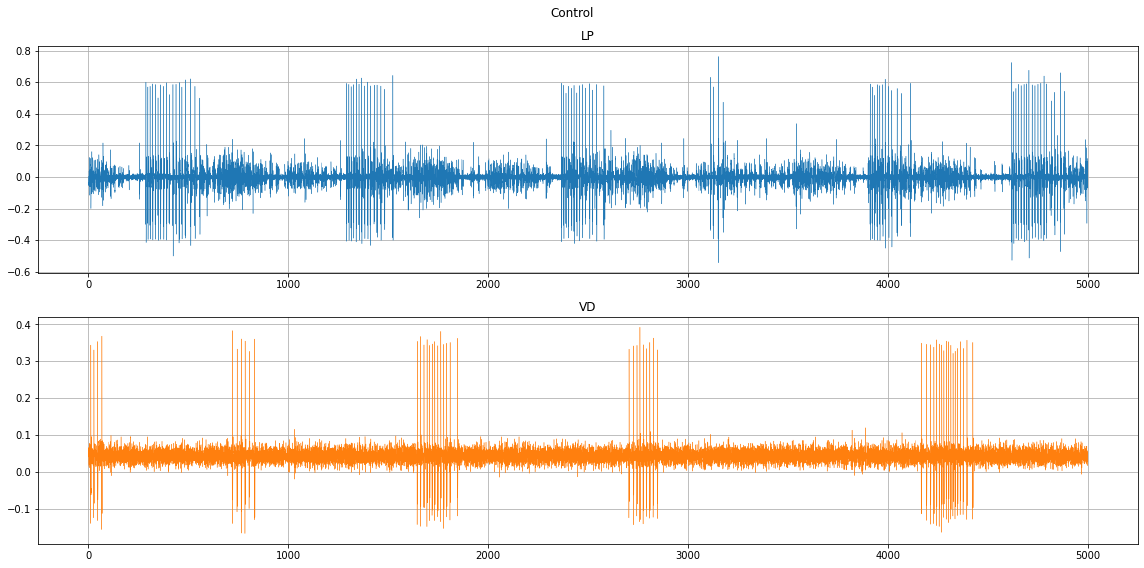

In [6]:
n = 50000
dt = 0.1
t = np.arange(0, n*dt, dt)
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.grid(True)
ax1.plot(t,trozoC['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")

ax2.plot(t,trozoC['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

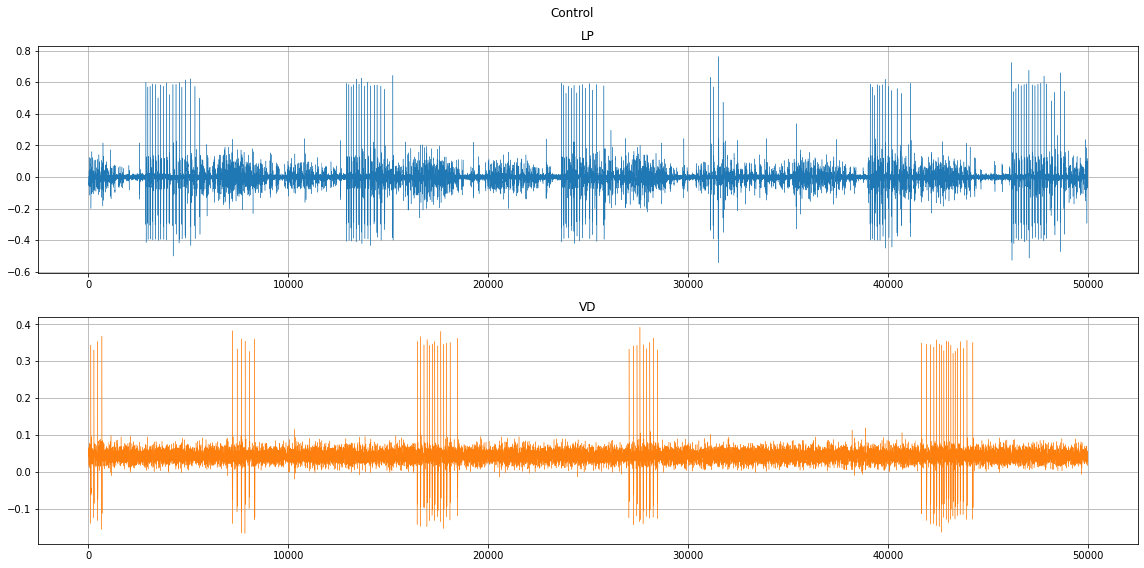

In [7]:
n = 50000
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.plot(trozoC['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")
ax1.grid(True)

ax2.plot(trozoC['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

## Detección de Spikes

#### Utilizando método estadístico

In [8]:
trozoC.describe()

,LP,VD
count,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02
std,8.214042e-02,3.287948e-02
min,-7.101440e-01,-2.170715e+00
25%,-2.288800e-02,3.295900e-02
50%,3.050000e-04,4.364000e-02
75%,2.410900e-02,5.401600e-02
max,9.344480e-01,1.351624e+00


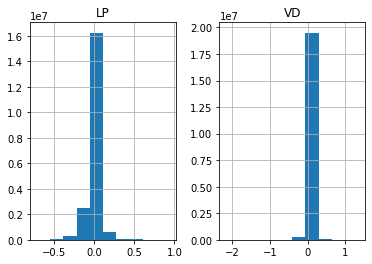

In [9]:
histogram = trozoC.hist()
plt.show()

In [10]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def get_threshold(df):
    return my_ceil(df.mean() + 4*df.std(),2)

In [11]:
threshold = get_threshold(trozoC)
threshold

LP    0.33
VD    0.18
dtype: float64

#### Utilizando la propia función de scipy

In [12]:
n = 50000
peaks, _ = find_peaks(trozoC.LP[:n], threshold[0])
print(peaks)

[ 2878  2975  3086  3216  3349  3484  3609  3765  3912  4044  4230  4384
  4546  4678  4849  5115  5331  5574 12918 13032 13146 13269 13407 13541
 13675 13825 13979 14105 14302 14444 14635 14821 15234 23673 23785 23898
 24024 24179 24300 24440 24576 24726 24873 25081 25223 25432 25793 31127
 31268 31519 31760 35420 39120 39220 39337 39470 39600 39750 39868 40047
 40199 40468 40691 41126 46204 46299 46411 46537 46671 46819 46947 47061
 47224 47363 47514 47658 47818 47943 48180 48353 48637 48834]


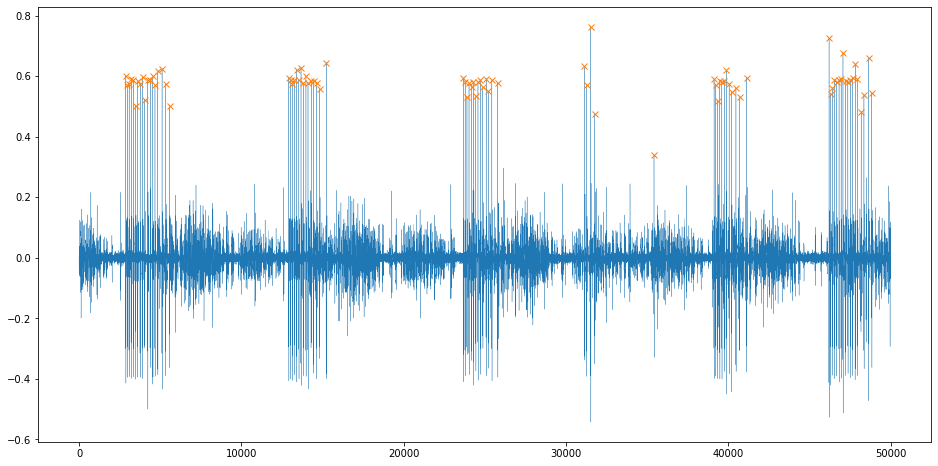

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(trozoC.LP[:n], lw=0.3)
plt.plot(peaks, trozoC.LP[:n][peaks], "x")
plt.show()

### Discretización

In [14]:
def discretize(df,threshold):
    return (df>threshold).astype(int)

In [15]:
trozoC_d = discretize(trozoC,threshold)
trozoC_d.head()

,LP,VD
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


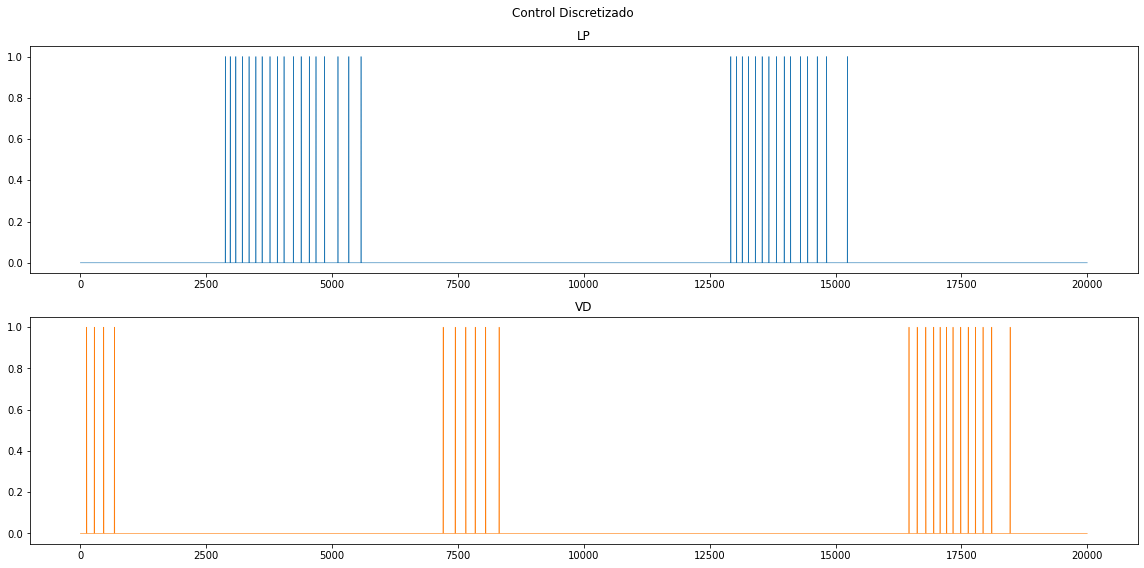

In [16]:
n = 20000

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control Discretizado')

ax1.plot(trozoC_d['LP'].iloc[:n],lw=0.6)
ax1.set_title("LP")

ax2.plot(trozoC_d['VD'].iloc[:n],'tab:orange',lw=0.6)
ax2.set_title("VD")

fig.tight_layout()

In [17]:
# Number of spikes detected
n_spikes = trozoC_d.sum()
n_spikes

LP    151648
VD    172514
dtype: int64

In [18]:
def get_spikes_index(df,column):
    return df[df[column]==1].index

In [89]:
lp_peaks = find_peaks(trozoC.LP, threshold[0])[0]
vd_peaks = find_peaks(trozoC.VD, threshold[1])[0]

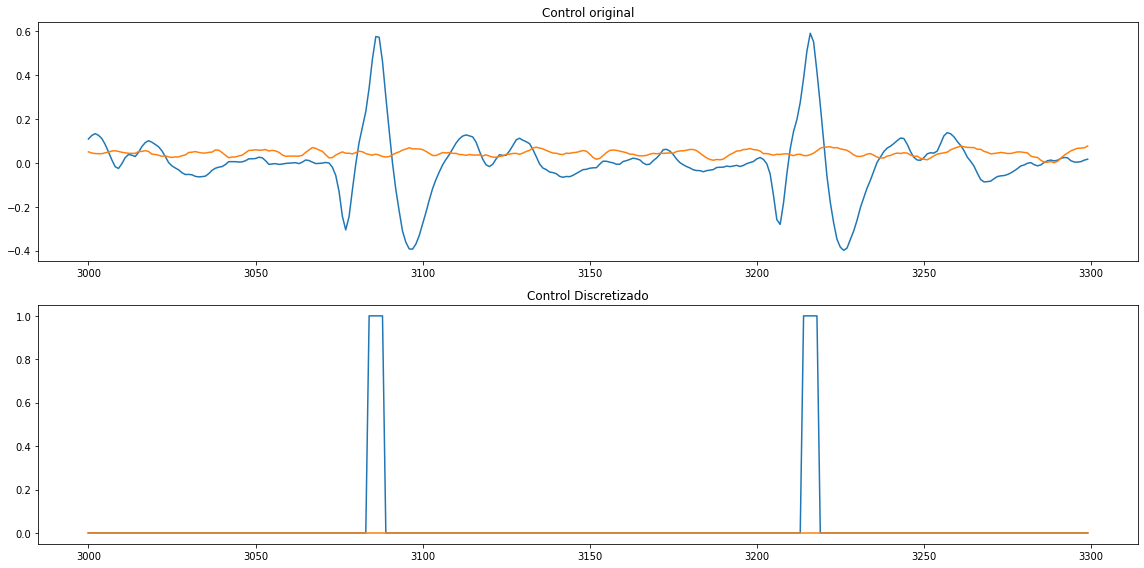

In [90]:
#Momento en el que se ve un spike!
i = 3000
f = 3300

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(16, 8)
#fig.suptitle('Control Discretizado')

ax1.plot(trozoC['LP'].iloc[i:f])
ax1.plot(trozoC['VD'].iloc[i:f])
ax1.set_title("Control original")


ax2.plot(trozoC_d['LP'].iloc[i:f])
ax2.plot(trozoC_d['VD'].iloc[i:f],'tab:orange')
ax2.set_title("Control Discretizado")

fig.tight_layout()

## Tamaño de la ventana

In [91]:
control_lp_distances = np.diff(lp_peaks)
control_vd_distances = np.diff(vd_peaks)

In [92]:
print('Min = ', np.amin(control_lp_distances))
print('Max = ',np.amax(control_lp_distances))
print('Mean = ',np.mean(control_lp_distances))
print('Medium = ',np.median(control_lp_distances))
print('Q1 = ',np.quantile(control_lp_distances, 0.00025))

Min =  3
Max =  20759
Mean =  626.8391040626777
Medium =  154.0
Q1 =  5.0


In [93]:
print('Min = ', np.amin(control_vd_distances))
print('Max = ',np.amax(control_vd_distances))
print('Mean = ',np.mean(control_vd_distances))
print('Medium = ',np.median(control_vd_distances))
print('Q1 = ',np.quantile(control_vd_distances, 0.00025))

Min =  4
Max =  29910
Mean =  887.0279864091559
Medium =  160.0
Q1 =  9.591750000000001


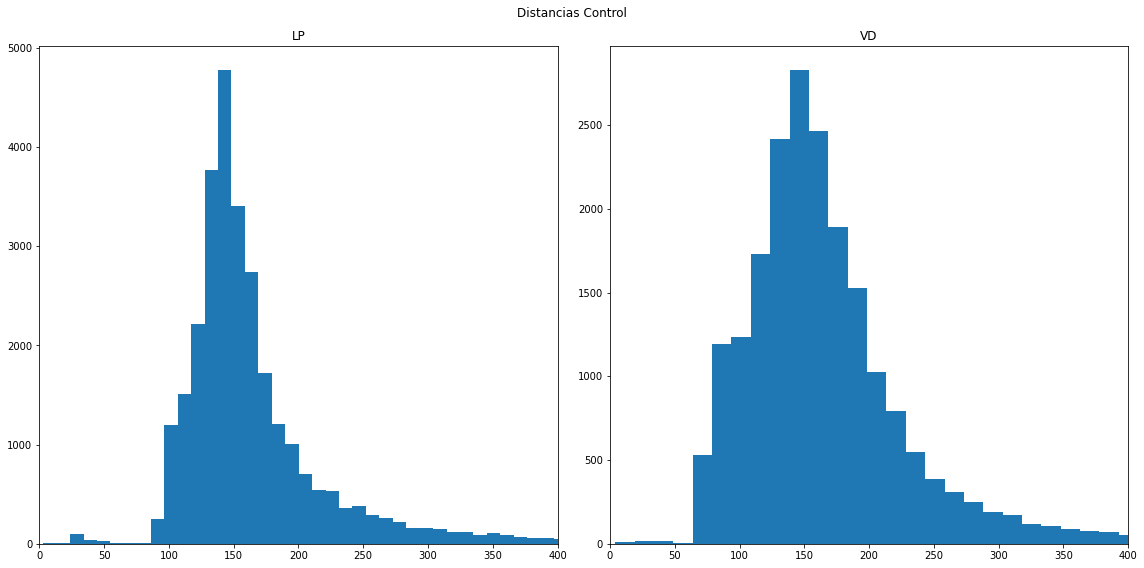

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Distancias Control')

ax1.hist(control_lp_distances,bins=2000)
ax1.set_xlim((0, 400))
ax1.set_title("LP")


ax2.hist(control_vd_distances,bins=2000)
ax2.set_title("VD")
ax2.set_xlim((0, 400))

fig.tight_layout()

In [95]:
# Queremos maximizar la distancia entre spikes para no contar spikes consecutivos que pueden pertener a un mismo spike,
# para ello, volvemos a llamar a la funcion find_peaks de manera que la distancia entre spike sea menor que la distancia obtenida del rpimer quartile

In [96]:
q1_lp = np.quantile(control_lp_distances, 0.00025)
lp_peaks, _ = find_peaks(trozoC.LP,height=threshold[0], distance=q1_lp)
print(lp_peaks)
lp_distance = np.diff(lp_peaks)
print('Min = ', np.amin(lp_distance))
print('Max = ',np.amax(lp_distance))
print('Mean = ',np.mean(lp_distance))
print('Medium = ',np.median(lp_distance))

[    2878     2975     3086 ... 19844306 19844484 19844843]
Min =  5
Max =  20759
Mean =  626.9579436299292
Medium =  154.0


In [97]:
q1_vd = np.quantile(control_vd_distances, 0.00025)
vd_peaks, _ = find_peaks(trozoC.VD,height=threshold[1], distance=q1_vd)
print(vd_peaks)
vd_distance = np.diff(vd_peaks)
print('Min = ', np.amin(vd_distance))
print('Max = ',np.amax(vd_distance))
print('Mean = ',np.mean(vd_distance))
print('Medium = ',np.median(vd_distance))

[     121      276      461 ... 19840843 19840987 19841163]
Min =  10
Max =  29910
Mean =  887.265986942134
Medium =  160.0


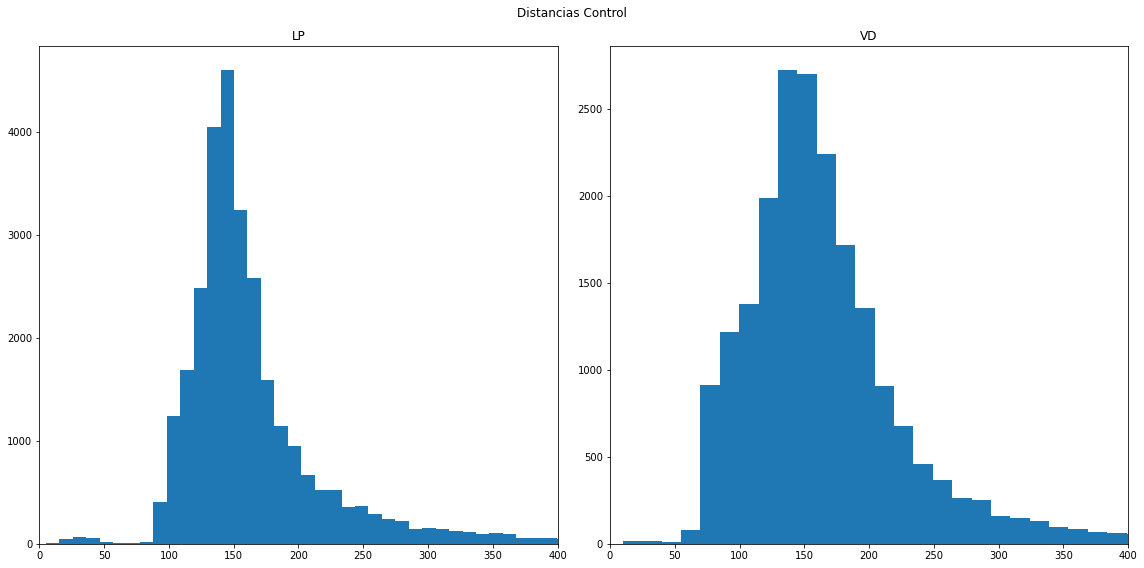

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Distancias Control')

ax1.hist(lp_distance,bins=2000)
ax1.set_xlim((0, 400))
ax1.set_title("LP")


ax2.hist(vd_distance,bins=2000)
ax2.set_title("VD")
ax2.set_xlim((0, 400))

fig.tight_layout()

In [99]:
trozoC['LP_events'] = 0
trozoC.LP_events[lp_peaks] = 1
trozoC['VD_events'] = 0
trozoC.VD_events[vd_peaks] = 1

/tmp/ipykernel_8259/930172639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trozoC.LP_events[lp_peaks] = 1
/tmp/ipykernel_8259/930172639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trozoC.VD_events[vd_peaks] = 1


In [136]:
bin_sizes = np.linspace(5,15,1).astype(int)

lp_bins = np.array([view_as_windows(np.array(trozoC.LP_events),window_shape=b, step=b)[None] for b in bin_sizes])
print(lp_bins.shape)

#peaks_by_bin = lp_bins.sum(axis=0)
#lp_bins.apply_along_axis(np.sum(),1)
#peaks_by_bin = lp_bins.sum(axis=1)
#(peaks_by_bin<=1).all()
peaks_by_bin

(1, 1, 3969540, 5)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [49]:
def get_errors_rate(df, n):
    A = df.groupby(df.index // n).sum()
    return A[A>1].count()/len(A)

In [50]:
rate = [get_errors_rate(trozoC_d_c, bin_size) for bin_size in range(1,170)]

In [52]:
lp_rate= [r.LP for r in rate]
vd_rate =  [r.VD for r in rate]

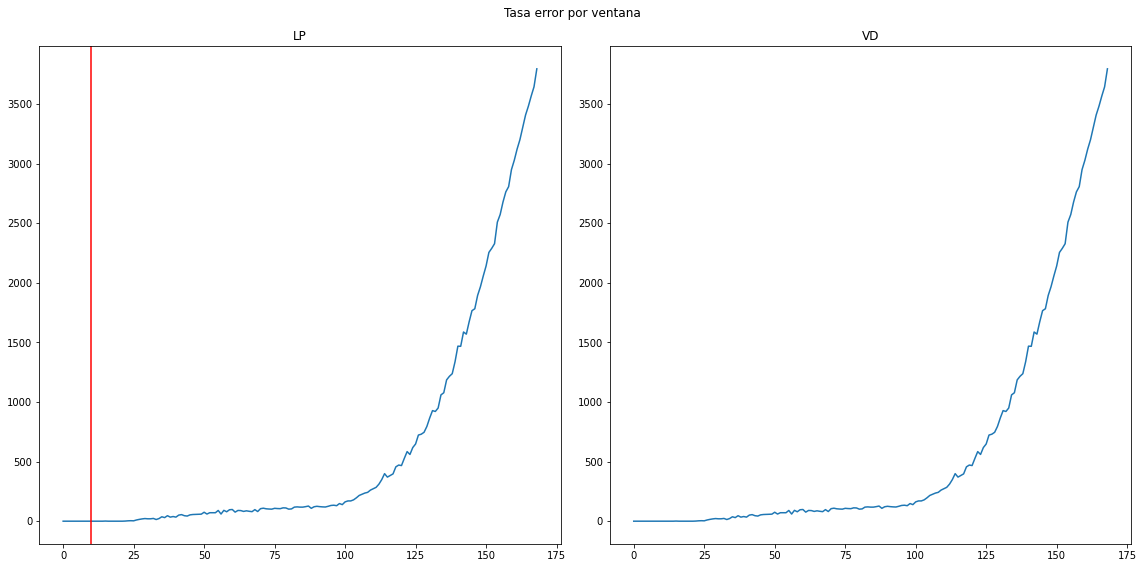

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Tasa error por ventana')

ax1.plot(lp_rate)
ax1.set_title("LP")
ax1.axvline(x=10, color='r')

ax2.plot(vd_rate)
ax2.set_title("VD")


fig.tight_layout()

In [ ]:
### INFORMACION MUTUA A NIVEL DE PALABRA POR BIT!!

### 0.8-1.2